In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow


from flowjax.tasks import two_moons
from flowjax.train import fit_to_data

In [2]:
import os
os.chdir('../')

In [3]:

from src.NF_Jax import JaxNormFlow

/opt/homebrew/Caskroom/miniforge/base/envs/flowjax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
j=JaxNormFlow()


In [5]:
j.train()

100%|██████████| 15/15 [03:31<00:00, 14.11s/it, train=-10.950839, val=-10.848843]


In [6]:
flow=j.flow

In [7]:
import jax.random as jr


In [8]:
import matplotlib.pyplot as plt

In [10]:
model_loaded.flow

Transformed(
  base_dist=Normal(
    base_dist=StandardNormal(shape=(6,)),
    bijection=Affine(
      shape=(6,),
      loc=f32[6],
      scale=BijectionReparam(
        _dummy=f32[],
        arr=f32[6],
        bijection=SoftPlus(shape=())
      )
    )
  ),
  bijection=Invert(
    bijection=Scan(
      bijection=Chain(
        shape=(6,),
        cond_shape=None,
        bijections=(
          MaskedAutoregressive(
            shape=(6,),
            cond_shape=None,
            transformer_constructor=<function constructor>,
            masked_autoregressive_mlp=MLP(
              layers=(
                Linear(
                  weight=Where(
                    cond=bool[10,100,6],
                    if_true=f32[10,100,6],
                    if_false=0
                  ),
                  bias=f32[10,100],
                  in_features=6,
                  out_features=100,
                  use_bias=True
                ),
                Linear(
                  weight=Wh

In [11]:
flow=model_loaded.flow

In [12]:
key, subkey = jr.split(model_loaded.key)
x_samples = flow.sample(subkey, (len(model_loaded.data),))



In [13]:
x_samples

Array([[-0.39364123, -0.5242652 , -0.01250113, -0.22616446, -0.01599927,
        -0.35790136],
       [-0.3850399 , -0.588124  , -0.09474344, -0.2866464 , -0.09650566,
        -0.42105502],
       [-1.1424541 , -0.9880033 , -0.24749435, -0.54965556, -0.25230914,
        -0.7600028 ],
       ...,
       [-0.44312993, -0.7803233 , -0.23642434, -0.42219853, -0.23723279,
        -0.5882457 ],
       [ 1.3396838 ,  0.59180635,  0.14775363,  0.3311332 ,  0.14633039,
         0.46629137],
       [-0.9587837 , -0.7386747 , -0.08839376, -0.35289583, -0.08842231,
        -0.52529573]], dtype=float32)

In [14]:
import seaborn as sn

In [15]:
model_loaded.data.shape

(140839, 6)

<Axes: ylabel='Density'>

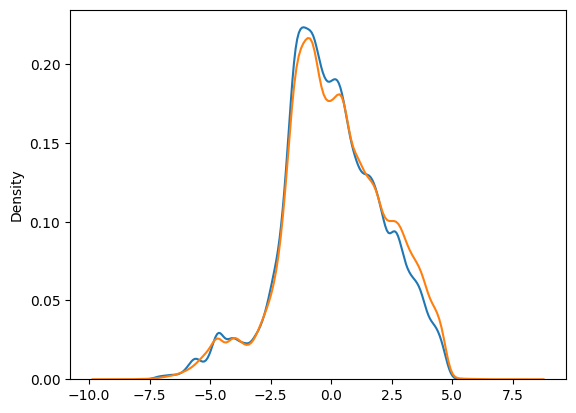

In [17]:
sn.kdeplot(model_loaded.data[:,0])
sn.kdeplot(x_samples[:,0])

In [18]:
import numpyro

In [19]:
import flowjax

In [4]:
"""Utilities for interfacing with numpyro.

Note these utilities require `numpyro <https://github.com/pyro-ppl/numpyro>`_ to be
installed.
"""

from __future__ import annotations

from typing import Any

import equinox as eqx
import jax
from jax import Array
from jax.typing import ArrayLike

from flowjax import wrappers
from flowjax.bijections import AbstractBijection
from flowjax.distributions import AbstractDistribution, AbstractTransformed
from flowjax.utils import _VectorizedBijection, arraylike_to_array

try:
    import numpyro
except ImportError as e:
    e.add_note(
        "Note, in order to interface with numpyro, it must be installed. Please see "
        "https://num.pyro.ai/en/latest/getting_started.html#installation",
    )
    raise

from numpyro.distributions.constraints import (
    _IndependentConstraint,
    _Real,
)
from numpyro.distributions.transforms import IndependentTransform, biject_to

PyTree = Any


class _RealNdim(_IndependentConstraint):
    def __init__(self, event_dim: int):
        super().__init__(_Real(), event_dim)


@biject_to.register(_RealNdim)
def _biject_to_independent(constraint):
    return IndependentTransform(
        biject_to(constraint.base_constraint),
        constraint.reinterpreted_batch_ndims,
    )


def sample(name: str, fn: Any, *args, condition=None, **kwargs):
    """Numpyro sample wrapper that wraps flowjax distributions.

    Args:
        name: Name of the sample site.
        fn: A flowjax distribution, numpyro distribution or a stochastic function that
            returns a sample.
        condition: Conditioning variable if fn is a conditional flowjax distribution.
            Defaults to None.
        *args: Passed to numpyro sample.
        **kwargs: Passed to numpyro sample.
    """
    if isinstance(fn, AbstractDistribution):
        fn = distribution_to_numpyro(fn, condition)

    return numpyro.sample(name, fn, *args, **kwargs)


def register_params(
    name: str,
    model: PyTree,
):
    """Register numpyro params for an arbitrary pytree.

    This partitions the parameters and static components, registers the parameters using
    numpyro.param, then recombines them. This should be called from within an inference
    context to have an effect, e.g. within a numpyro model or guide function.

    Args:
        name: Name for the parameter set.
        model: The pytree (e.g. an equinox module, flowjax distribution/bijection).
    """
    params, static = eqx.partition(
        model,
        eqx.is_inexact_array,
        is_leaf=lambda leaf: isinstance(leaf, wrappers.NonTrainable),
    )
    if callable(params):
        # Wrap to avoid special handling of callables by numpyro. Numpyro expects a
        # callable to be used for lazy initialization, whereas in our case it is likely
        # a callable module we wish to train.
        params = numpyro.param(name, lambda _: params)
    else:
        params = numpyro.param(name, params)
    return wrappers.unwrap(eqx.combine(params, static))


def distribution_to_numpyro(
    dist: AbstractDistribution,
    condition: ArrayLike | None = None,
):
    """Convert a flowjax distribution to a numpyro distribution.

    Args:
        dist (AbstractDistribution): Flowjax distribution
        condition: condition: Conditioning variables. Any leading batch dimensions will
            be converted to batch dimensions in the numpyro distribution. Defaults to
            None.
    """
    if isinstance(dist, AbstractTransformed):
        return _transformed_to_numpyro(dist, condition)
    return _DistributionToNumpyro(dist, condition)


class _DistributionToNumpyro(numpyro.distributions.Distribution):
    """Convert a AbstractDistribution to a numpyro distribution.

    Note that for transformed distributions, ``_transformed_to_numpyro`` should be used
    instead.
    """

    dist: AbstractDistribution
    _condition: Array

    def __init__(
        self,
        dist: AbstractDistribution,
        condition: ArrayLike | None = None,
    ):
        self.dist = dist

        if condition is not None:
            condition = arraylike_to_array(condition, "condition")
        self._condition = condition
        self.support = _RealNdim(dist.ndim)
        batch_shape = _get_batch_shape(condition, dist.cond_shape)
        super().__init__(batch_shape, dist.shape)

    @property
    def condition(self):
        return jax.lax.stop_gradient(self._condition)

    def sample(self, key, sample_shape=()):
        return self.dist.sample(key, sample_shape, self.condition)

    def log_prob(self, value):
        return self.dist.log_prob(value, self.condition)


def _transformed_to_numpyro(dist, condition=None):
    dist = dist.merge_transforms()  # Ensure base dist not transformed

    if condition is not None:
        condition = arraylike_to_array(condition, "condition")

    if dist.base_dist.cond_shape is not None:
        base_dist = _DistributionToNumpyro(dist.base_dist, condition)
    else:
        # add batch dimension to the base dist if condition is batched
        batch_shape = _get_batch_shape(condition, dist.cond_shape)
        base_dist = _DistributionToNumpyro(dist.base_dist).expand(batch_shape)

    transform = _BijectionToNumpyro(dist.bijection, condition)
    return numpyro.distributions.TransformedDistribution(base_dist, transform)


def _get_batch_shape(condition, cond_shape):
    if condition is not None:
        if len(cond_shape) > 0:
            return condition.shape[: -len(cond_shape)]
        return condition.shape
    return ()


class _BijectionToNumpyro(numpyro.distributions.transforms.Transform):
    """Wrap a numpyro AbstractBijection to a numpyro transform."""

    def __init__(
        self,
        bijection: AbstractBijection,
        condition: Array = None,
        domain=None,
        codomain=None,
    ):
        self.bijection = bijection
        self._condition = condition

        if domain is None:
            domain = _RealNdim(len(bijection.shape))
        if codomain is None:
            codomain = _RealNdim(len(bijection.shape))
        self.domain = domain
        self.codomain = codomain
        self._argcheck_domains()

    def __call__(self, x):
        return self.vbijection.transform(x, self.condition)

    def _inverse(self, y):
        return self.vbijection.inverse(y, self.condition)

    def log_abs_det_jacobian(self, x, y, intermediates=None):
        if intermediates is not None:
            return intermediates  # Logdet calculated with forward transformation
        return self.vbijection.transform_and_log_det(x, self.condition)[1]

    def call_with_intermediates(self, x):
        return self.vbijection.transform_and_log_det(x, self.condition)

    @property
    def condition(self):
        return jax.lax.stop_gradient(self._condition)

    @property
    def vbijection(self):
        return _VectorizedBijection(self.bijection)

    def tree_flatten(self):
        raise NotImplementedError()

    def _argcheck_domains(self):
        for k, v in {"domain": self.domain, "codomain": self.codomain}.items():
            if v is not None and v.event_dim != len(self.bijection.shape):
                raise ValueError(
                    f"{k}.event_dim {v.event_dim} did not match the length of the "
                    f"bijection shape {len(self.bijection.shape)}.",
                )

/opt/homebrew/Caskroom/miniforge/base/envs/flowjax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
dist_nf=distribution_to_numpyro(model_loaded.flow)

In [23]:
extinction_vector=model_loaded.extinction_vector[1:]

In [24]:
extinction_vector

Array([0.825     , 0.932     , 0.14599998, 0.427     , 0.14599998,
       0.63199997], dtype=float32)

In [25]:
import pandas as pd


test_file='/Users/mattocallaghan/XPNorm/Data/data_black_1'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_black_circle'

#test_file='/Users/mattocallaghan/XPNorm/Data/data_red_circle'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_black_circle_20'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_noext'

err_file='/Users/mattocallaghan/XPNorm/Data/err_black_1'

#test_file='/Users/mattocallaghan/XPNorm/Data/data_full_1'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_black_circle'

#test_file='/Users/mattocallaghan/XPNorm/Data/data_red_circle'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_black_circle_20'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_noext'

err_file='/Users/mattocallaghan/XPNorm/Data/err_black_1'


data=pd.read_csv(test_file)[['mu','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','j_m','h_m','ks_m']].sort_values(by='mu',ascending=True)
idx=data.index
data=data.values
mu=data[:,0]
distance=10**((data[:,0]+5)/5)
data_err=pd.read_csv(err_file)[['mu_error','g_error','bp_error','rp_error','j_msigcom','h_msigcom','ks_msigcom']].values[idx]
mu_err=data_err[:,0]



data_transform=model_loaded.data_transform

g = jnp.array([0.7, 0.95])
bp =  jnp.array([0.97, 1.28])
rp =  jnp.array([0.55, 0.69])
j =  jnp.array([0.71, 0.73])/3.1
h =  jnp.array([0.45, 0.47])/3.1
ks =  jnp.array([0.34, 0.36])/3.1

error=jnp.stack([jnp.diag(arr**2) for arr in data_err])

data=jnp.einsum('ij,bj->bi',jnp.array(data_transform),jnp.array(data))
error=(jnp.einsum('ik,bkj->bij',(jnp.array(data_transform)),error))

error=(jnp.einsum('bik,kj->bij',error,jnp.array(data_transform).transpose()))
#cut_1=(data[:,1]<10)*(data[:,1]>-2)
#cut_2=(data[:,0]<20)#*(data[:,0]>2)
#data=data[cut_1*cut_2]

#data=data[cut_2]
#mu=mu[cut_1*cut_2]
#mu_err=mu_err[cut_1*cut_2]
#error=error[cut_1*cut_2]
#error=error[cut_2]
#distance=distance[cut_1*cut_2]
data=data[:,1:]
error=error[:,1:,1:]



data=(data-model_loaded.mean)





In [ ]:
error[0]

Array([[0.00104332, 0.001024  , 0.001024  , 0.001024  , 0.001024  ],
       [0.001024  , 0.001553  , 0.001024  , 0.001553  , 0.001024  ],
       [0.001024  , 0.001024  , 0.00103464, 0.001024  , 0.001024  ],
       [0.001024  , 0.001553  , 0.001024  , 0.001553  , 0.001024  ],
       [0.001024  , 0.001024  , 0.001024  , 0.001024  , 0.00103316]],      dtype=float32)

In [26]:
coeffs= jnp.array([
        [0.194059063720102, -0.000337880688254366, 0.000405004510990789, -0.000119030825664077, -2.90629429374213e-05, 9.85596051245887e-09, 1.22296149043372e-10, 0, 0, 0],
        [0.255058871064972, 7.19016588950228e-05, -0.000250455702483274, 3.99422163967702e-05, -6.83632867675118e-05, -2.3163568526324e-09, 7.26631781961228e-10, -2.27788077229475e-07, 4.97609167483581e-07, 6.67076034469308e-09],
        [0.340301468237771, -0.000826269158576803, -0.000283696380615497, 0.000103538996307887, -0.000156039957793959, 1.81587525109325e-07, 2.33928990111011e-09, 1.63733498839871e-06, 5.71693287820809e-08, 2.954302715354e-08],
        [0.663374149569189, -0.0184814428792349, 0.0100266536020118, -0.00317119320308867, -0.00649336268398495, 3.27674122186053e-05, 1.57894227641494e-06, -0.000116290469708794, 0.000117366662432525, 6.91273258513903e-06],
        [1.1516008149802, -0.0502982507379423, -0.00801054248601918, 0.0028487377407222, -0.0222045923218139, 0.000841943191161668, -1.31018008013547e-05, 0.00346423295251231, -0.000145621334026214, -6.85718568409361e-05],
        [0.993548688906439, -0.110149052160837, 0.0264447715065468, -0.00571010222810317, -0.0374363031107716, 0.00151447309438712, -2.52364537395156e-05, 0.00623824755961677, -0.000123598316318183, -0.000158499801004388]
        ])




def f(x,a,i):

    coeff=coeffs[i]
    result=coeff[0]*jnp.ones_like(x)
    result+=coeff[1]*x
    result+=coeff[2]*x**2
    result+=coeff[3]*x**3

    result+=coeff[4]*a
    result+=coeff[5]*a**2
    result+=coeff[6]*a**3

    result+=coeff[7]*x*a
    result+=coeff[8]*a*x**2
    result+=coeff[9]*x*a**2
    return result


In [48]:
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
import numpyro

def model(data,err):
    # Prior distribution for the mean

    with numpyro.plate('data', len(data)):
        a0 = numpyro.sample('a0', dist.Uniform(-0.0,0.5))
        x = numpyro.sample('x', dist_nf)
        extinction_vector=jnp.stack([f((x+model_loaded.mean)[:,-1],a0,i) for i in jnp.arange(5,-1,-1)]).T
        extinction_vector=(jnp.einsum('ij,bj->bi',(model_loaded.data_transform[1:,1:]),extinction_vector))
        
        x_obs=x+(a0[:,None]*extinction_vector)

        numpyro.sample('obs', dist.MultivariateNormal(loc=x_obs,covariance_matrix=err+1e-3*jnp.eye(6)), obs=data)
        # Observed data is sampled from a Gaussian distribution
        

In [49]:
model_loaded.extinction_vector

Array([0.        , 0.825     , 0.932     , 0.14599998, 0.427     ,
       0.14599998, 0.63199997], dtype=float32)

In [50]:
def is_pos_def(x):
    return jnp.all(jnp.linalg.eigvals(x) > 0)
is_pos_def(error[34:35])

Array(True, dtype=bool)

In [3]:
from Inference_MCMC import Inference

ModuleNotFoundError: No module named 'src'

In [51]:
jnp.linalg.eigvals(error[34:35])

Array([[4.3548383e-03+0.j, 1.2543109e-02+0.j, 7.2335202e-04+0.j,
        1.3362686e-05+0.j, 9.5234864e-06+0.j, 2.4017423e-11+0.j]],      dtype=complex64)

In [52]:
len(data)

49

In [53]:
data[35:36]

Array([[-1.3352022 , -0.5507021 , -0.2664745 , -0.3573556 , -0.2664745 ,
        -0.42996764]], dtype=float32)

In [79]:



nuts_kernel = HMC(model)

mcmc = MCMC(nuts_kernel, num_warmup=3000, num_samples=1000)


rng_key = random.PRNGKey(0)

mcmc.run(rng_key, data[0:1],error[0:1])


warmup:   0%|          | 5/4000 [00:12<2:58:21,  2.68s/it, 5874 steps of size 6.62e-05. acc. prob=0.00]

In [55]:
data.shape

(49, 6)

In [ ]:
model_loaded.data_transform.sum(-1)

Array([ 0.        ,  0.27636486,  0.02444655, -0.00871763,  0.02337338,
       -0.9153009 ,  0.5998339 ], dtype=float32)

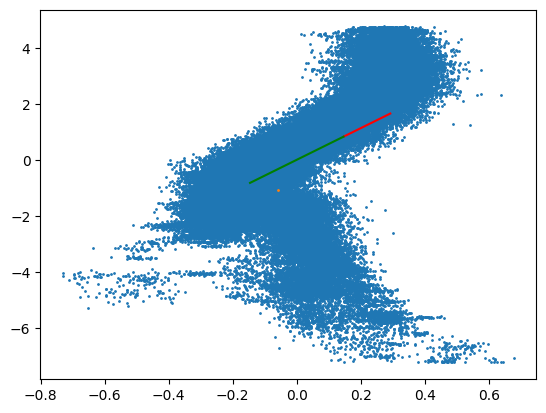

In [67]:
plt.scatter(model_loaded.data[:,2],model_loaded.data[:,0],s=1)
#plt.scatter(data[:,2]-data[:,1],data[:,0])
plt.scatter(data[10:11,2],data[10:11,0],s=1)
g=model_loaded.extinction_vector[1]
c=model_loaded.extinction_vector[3]#-model_loaded.extinction_vector[2]
arr=jnp.array([[c,g],[2*c,2*g]])

plt.plot(arr[:,0],arr[:,1],c='r')
arr=jnp.array([[c,g],[-1*c,-1*g]])
plt.plot(arr[:,0],arr[:,1],c='g')

In [66]:
(mcmc.get_samples()['a0'][:,0]/3.1).mean()

Array(0.06470565, dtype=float32)

(array([204., 118.,  97., 110., 106., 104.,  73.,  67.,  66.,  55.]),
 array([0.00060661, 0.01663574, 0.03266487, 0.048694  , 0.06472313,
        0.08075226, 0.09678139, 0.11281052, 0.12883966, 0.14486878,
        0.16089791]),
 <BarContainer object of 10 artists>)

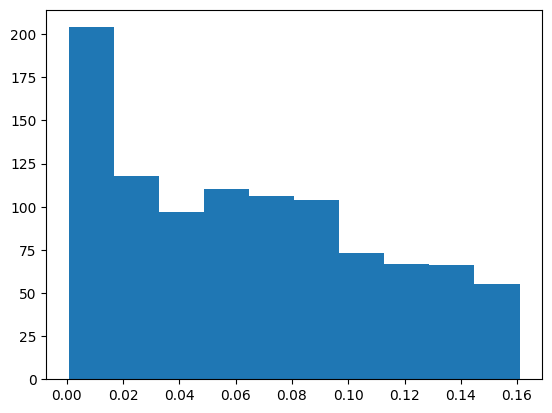

In [62]:
plt.hist(mcmc.get_samples()['a0'][:,0]/3.1)

In [ ]:
mcmc.get_samples()['a0'].mean()

Array(0.00106245, dtype=float32)

(array([287., 263., 189., 133.,  66.,  32.,  17.,   5.,   4.,   4.]),
 array([3.22942867e-07, 4.94246371e-04, 9.88169806e-04, 1.48209312e-03,
        1.97601668e-03, 2.46994011e-03, 2.96386331e-03, 3.45778675e-03,
        3.95171018e-03, 4.44563385e-03, 4.93955705e-03]),
 <BarContainer object of 10 artists>)

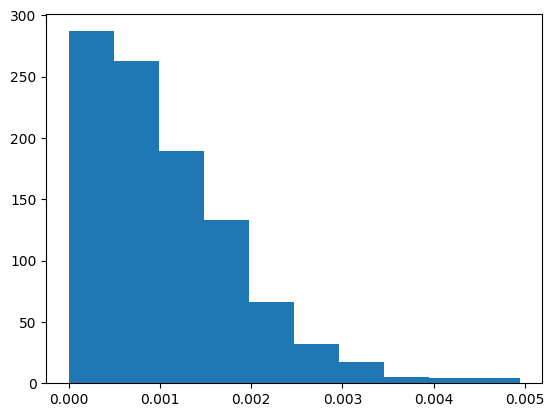

In [ ]:
plt.hist(mcmc.get_samples()['a0'][:,0])

In [ ]:
mcmc.get_samples()['a0'].std()

Array(0.15801777, dtype=float32)

In [ ]:
mcmc.get_samples()['a0'].std()

Array(0.20357938, dtype=float32)

In [68]:

from numpyro.infer import SVI, Trace_ELBO
import numpyro.optim as optim
from numpyro.infer import (
    MCMC, NUTS, SVI, autoguide,
    Trace_ELBO, Predictive, autoguide
)
guide = autoguide.AutoNormal(model)
svi = SVI(
    model=model, 
    data=data[0:20],
    err=error[0:20],
    guide=guide, 
    optim=optim.Adam(step_size=0.01), 
    loss=Trace_ELBO()
)
svi_result = svi.run(
    rng_key=rng_key, 
    num_steps=10000
)
params = svi_result.params
posteriors = guide.sample_posterior(rng_key, params, sample_shape=(10000,))

100%|██████████| 10000/10000 [01:45<00:00, 94.39it/s, init loss: 63227.1875, avg. loss [9501-10000]: 105.7153]


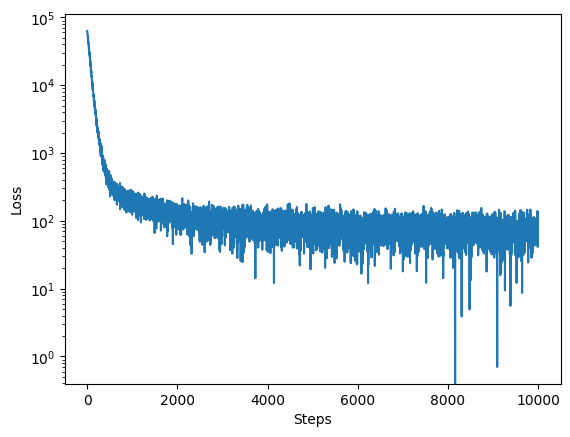

In [69]:
fig, ax = plt.subplots()
ax.semilogy(svi_result.losses - svi_result.losses.min())
ax.set(
    xlabel='Steps',
    ylabel='Loss'
)
plt.show()

In [ ]:
from corner import corner
import numpy as np
import arviz

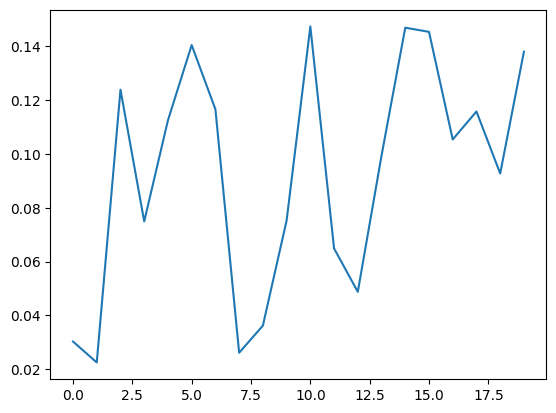

In [72]:


plt.plot(posteriors['a0'].mean(0)/3.1)

ValueError: 'x' and 'y' must have the same size

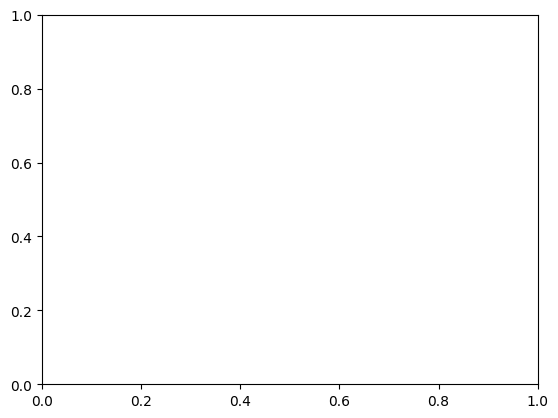

In [ ]:
import matplotlib.pyplot as plt

# Calculate means and standard deviations
means = posteriors['a0'][:,:].mean(0)
stds = posteriors['a0'][:,:].std(0)

# Plot with error bars
plt.errorbar(distance, means, yerr=stds, fmt='o')
plt.xlabel('Distance')
plt.ylabel('Means')
plt.title('Means with Error Bars')
plt.xlim(0,2000)
plt.show()


In [ ]:
posteriors['a0'].mean()

Array(0.09168431, dtype=float32)

In [ ]:
posteriors['a0'].std()

Array(0.04801047, dtype=float32)

In [ ]:
import numpy as np
import torch
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp

# Assuming you have a neural network defined using a framework like PyTorch
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the neural network
input_size = 1  # Assuming the input size is 1 (first data column)
hidden_size = 100  # Number of hidden units
output_size = 1  # Assuming a single output for a0
neural_net = NeuralNetwork(input_size, hidden_size, output_size)

def model(data, err,mu,mu_err):
    # Prior distribution for the neural network parameters
    weights = numpyro.sample('weights', dist.Normal(0, 10), sample_shape=(hidden_size, input_size))
    bias = numpyro.sample('bias', dist.Normal(0, 10), sample_shape=(hidden_size,))
    weights_out = numpyro.sample('weights_out', dist.Normal(0, 10), sample_shape=(output_size, hidden_size))
    #bias_out = numpyro.sample('bias_out', dist.Normal(0, 10), sample_shape=(output_size,))

    # Define a function to compute the output of the neural network
    def nn_forward(x):
        x = jnp.einsum('ij,bj->bi',weights, x) + bias
        x = jnp.maximum(0, x)  # ReLU activation
        x = jnp.einsum('ij,bj->bi',weights_out, x) #+ bias_out
        return x

    # Use the neural network to compute a0 based on the first data column
    

    with numpyro.plate('data', len(data)):
        # Sample latent variable x
        d = numpyro.sample('d', dist.Uniform(6.2,14))

        x = numpyro.sample('x', dist_nf)
        a0_pred = nn_forward(d[:,None])
        print(a0_pred)
        # Compute extinction vector using a0 predicted by the neural network
        extinction_vector = jnp.concat([f((x + model_loaded.mean)[:, -1:], a0_pred, i) for i in np.arange(5, -1, -1)],axis=1)
        extinction_vector = (jnp.einsum('ij,bj->bi', (model_loaded.data_transform[1:, 1:]), extinction_vector))

        # Add a0 * extinction_vector to x to obtain observed data
        x_obs = x + (a0_pred * extinction_vector)
        
        # Sample observed data from a Multivariate Normal distribution
        numpyro.sample('obs', dist.MultivariateNormal(x_obs, (err + 0.001)), obs=data)
        numpyro.sample('d_obs', dist.Normal(d, (mu_err**2)), obs=mu)
# Example of using SBI to infer the neural network parameters
# Here, you would perform SBI to infer the posterior distribution over the neural network parameters


In [ ]:
mu.max()

13.332965393469197

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


test_file='/Users/mattocallaghan/XPNorm/Data/data_black_1'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_black_circle'

#test_file='/Users/mattocallaghan/XPNorm/Data/data_red_circle'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_black_circle_20'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_noext'

err_file='/Users/mattocallaghan/XPNorm/Data/err_black_1'

test_file='/Users/mattocallaghan/XPNorm/Data/data_full_1'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_black_circle'

#test_file='/Users/mattocallaghan/XPNorm/Data/data_red_circle'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_black_circle_20'
#test_file='/Users/mattocallaghan/XPNorm/Data/data_noext'

err_file='/Users/mattocallaghan/XPNorm/Data/err_full_1'


data=pd.read_csv(test_file)[['mu','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','j_m','h_m','ks_m']].sort_values(by='mu',ascending=True)
idx=data.index
data=data.values
mu=data[:,0]
distance=10**((data[:,0]+5)/5)
data_err=pd.read_csv(err_file)[['mu_error','g_error','bp_error','rp_error','j_msigcom','h_msigcom','ks_msigcom']].values[idx]
mu_err=data_err[:,0]


mean_err=error.mean(0)

g = jnp.array([0.7, 0.95])
bp =  jnp.array([0.97, 1.28])
rp =  jnp.array([0.55, 0.69])
j =  jnp.array([0.71, 0.73])/3.1
h =  jnp.array([0.45, 0.47])/3.1
ks =  jnp.array([0.34, 0.36])/3.1



##error=jnp.sqrt(jnp.einsum('ij,bj->bi',jnp.abs(jnp.array(data_transform)),jnp.array(data_err[:,1:])**2))
##data=jnp.einsum('ij,bj->bi',jnp.array(data_transform),jnp.array(data[:,1:]))




# Assuming you have the 'data' array defined somewhere
#n=3
#m=-1
#plt.scatter(data[:, 4], data[:, 3], s=1)



#plt.show()

import numpy as np
from scipy.optimize import minimize

# Define custom loss function
def custom_loss_function(matrix):
    return np.linalg.norm(np.abs(matrix.reshape(6, 6)*mean_err).flatten())  # Frobenius norm

# Constraint function to ensure rows sum to zero
def constraint_function(matrix):
    return np.concatenate((np.sum(matrix.reshape(6, 6), axis=0),[np.linalg.det(matrix.reshape(6, 6))-1]))

# Initial guess for the matrix (random)
initial_guess = np.random.rand(6, 6)

# Define bounds for optimization (optional, but can help avoid numerical issues)
bounds = [(None, None)] * 36  # No bounds

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_function})

# Minimize the custom loss function subject to the constraint
result = minimize(custom_loss_function, initial_guess.flatten(), method='SLSQP', constraints=constraints, bounds=bounds)

# Extract the optimized matrix
optimized_matrix = result.x.reshape(6, 6)

print("Optimized Matrix:")
print(optimized_matrix)


Optimized Matrix:
[[-0.22304537 -0.32766834  0.0348135   0.94457389  0.18392385 -0.33623265]
 [-0.89544276 -2.09822894  0.84125632  1.26393528  0.23627151  0.67665502]
 [-0.00876676  0.85962479  0.47337703 -1.32566843 -0.04761568  0.04033142]
 [ 0.27728898 -0.84113109  0.03873685 -0.15023442  0.50000302  0.19870998]
 [ 0.37800676  1.29001659 -0.97373258  0.15118761 -0.97465738 -0.78612189]
 [ 0.47195914  1.117387   -0.41445112 -0.88379394  0.10207468  0.20665812]]


In [ ]:
optimized_matrix


array([[-0.22304537, -0.32766834,  0.0348135 ,  0.94457389,  0.18392385,
        -0.33623265],
       [-0.89544276, -2.09822894,  0.84125632,  1.26393528,  0.23627151,
         0.67665502],
       [-0.00876676,  0.85962479,  0.47337703, -1.32566843, -0.04761568,
         0.04033142],
       [ 0.27728898, -0.84113109,  0.03873685, -0.15023442,  0.50000302,
         0.19870998],
       [ 0.37800676,  1.29001659, -0.97373258,  0.15118761, -0.97465738,
        -0.78612189],
       [ 0.47195914,  1.117387  , -0.41445112, -0.88379394,  0.10207468,
         0.20665812]])

In [ ]:
result.x.reshape(6, 6).sum(0)

array([-9.43689571e-16, -1.77635684e-15, -1.66533454e-16, -1.11022302e-15,
       -7.77156117e-16, -2.22044605e-16])

In [ ]:
rng_key = jr.PRNGKey(0)


In [ ]:
idxs=(distance<=400)*(distance>=200)

from numpyro.infer import SVI, Trace_ELBO
import numpyro.optim as optim
from numpyro.infer import (
    MCMC, NUTS, SVI, autoguide,
    Trace_ELBO, Predictive, autoguide
)
guide = autoguide.AutoNormal(model)
svi = SVI(
    model=model, 
    data=data,
    err=error,
    mu=mu,
    mu_err=mu_err,
    guide=guide, 
    optim=optim.Adam(step_size=0.01), 
    loss=Trace_ELBO()
)
svi_result = svi.run(
    rng_key=rng_key, 
    num_steps=1000
)
params = svi_result.params
posteriors = guide.sample_posterior(rng_key, params, sample_shape=(1000,))

[[-30.6389  ]
 [-41.28203 ]
 [-29.00076 ]
 [-38.16189 ]
 [-41.981804]
 [-24.23234 ]
 [-29.306824]
 [-40.019794]
 [-39.729454]
 [-40.157524]
 [-23.795547]
 [-27.389175]
 [-33.456715]
 [-29.606731]
 [-41.020508]
 [-27.319717]
 [-37.650826]
 [-38.448074]
 [-43.18793 ]
 [-24.619492]
 [-26.920769]
 [-36.311104]
 [-36.821404]
 [-31.664787]
 [-38.692276]
 [-32.845505]
 [-23.695902]
 [-41.068275]
 [-42.945816]
 [-30.503593]
 [-42.160057]
 [-35.804207]
 [-26.557247]
 [-33.861572]
 [-26.538223]
 [-39.530434]
 [-42.096725]
 [-39.4432  ]
 [-34.09605 ]
 [-35.118317]
 [-39.720894]
 [-25.531147]
 [-40.58129 ]
 [-43.113556]
 [-36.762695]
 [-26.532963]
 [-33.097305]
 [-26.049839]
 [-26.689598]
 [-43.13523 ]
 [-30.759552]
 [-40.582848]
 [-25.673214]
 [-31.951553]
 [-29.499382]
 [-34.9103  ]
 [-27.115353]
 [-39.8443  ]
 [-24.933563]
 [-42.456657]
 [-38.813103]
 [-43.146706]
 [-32.536148]
 [-24.268486]
 [-36.12224 ]
 [-36.14139 ]
 [-33.889008]
 [-31.550217]
 [-33.2388  ]
 [-42.800453]
 [-28.023739]
 [-39.

  0%|          | 0/1000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[107,1])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[107,1])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[107,1])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[107,1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x2e981f680>, in_tracers=(Traced<ShapedArray(float32[1,100]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[107,100]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[1,100]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[107,100]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x2e8c88310; to 'JaxprTracer' at 0x2e8c76890>], out_avals=[ShapedArray(float32[107,1])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[1,100] b:f32[107,100] c:f32[1,100] d:f32[107,100]. let
    e:f32[107,1] = dot_general[
      dimension_numbers=(([1], [1]), ([], []))
      preferred_element_type=float32
    ] b c
    f:f32[107,1] = dot_general[
      dimension_numbers=(

 28%|██▊       | 278/1000 [00:16<00:42, 16.93it/s, init loss: 911401280.0000, avg. loss [201-250]: nan]           


KeyboardInterrupt: 

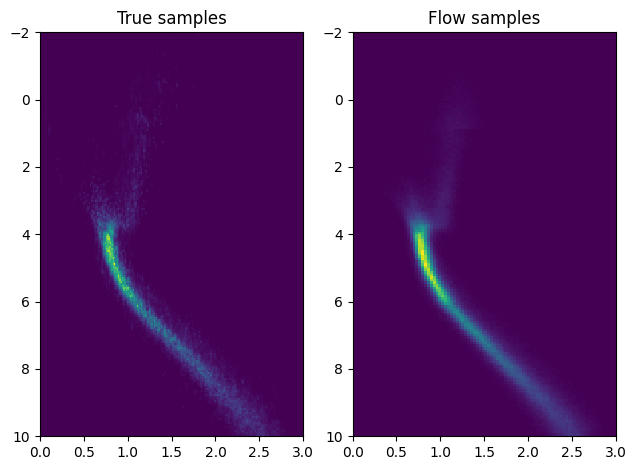

In [ ]:
fig, axs = plt.subplots(ncols=2)


axs[0].hist2d((j.data[:, 2]+j.mean[2])-(j.data[:, 1]+j.mean[1]), j.data[:, 0]+j.mean[0],bins=200)
axs[0].set_title("True samples")

axs[1].hist2d((x_samples[:, 2]+j.mean[2])-(x_samples[:, 1]+j.mean[1]), x_samples[:, 0]+j.mean[0],bins=200)
axs[1].set_title("Flow samples")



for ax in axs:
    ax.set_xlim(0,3.0)
    ax.set_ylim(10,-2)
#ax.set_aspect("equal")

plt.tight_layout()
plt.show()

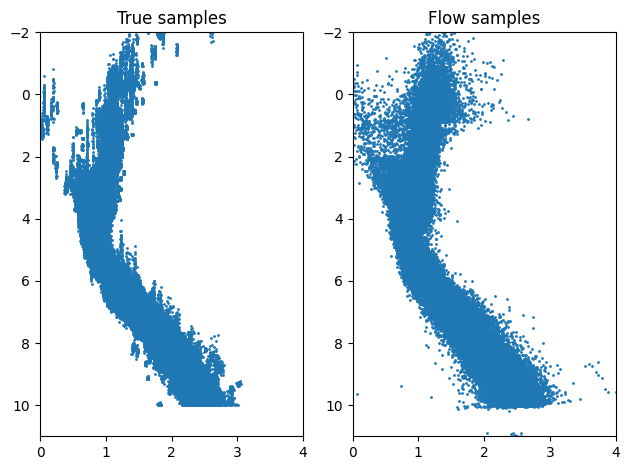

In [ ]:
fig, axs = plt.subplots(ncols=2)


axs[0].scatter((j.data[:, 2]+j.mean[2])-(j.data[:, 1]+j.mean[1]), j.data[:, 0]+j.mean[0],s=1)
axs[0].set_title("True samples")

axs[1].scatter((x_samples[:, 2]+j.mean[2])-(x_samples[:, 1]+j.mean[1]), x_samples[:, 0]+j.mean[0],s=1)
axs[1].set_title("Flow samples")



for ax in axs:
    ax.set_xlim(0,4.0)
    ax.set_ylim(11,-2)
#ax.set_aspect("equal")

plt.tight_layout()
plt.show()

In [ ]:
n_samples = 10000
x = two_moons(rng, n_samples)
x = (x - x.mean(axis=0)) / x.std(axis=0)  # Standardize

In [ ]:
key, subkey = jr.split(jr.PRNGKey(0))
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

In [ ]:
key, subkey = jr.split(key)
flow, losses = fit_to_data(subkey, flow, x, learning_rate=1e-3)

 31%|███       | 31/100 [00:12<00:27,  2.53it/s, train=1.5499363, val=1.5359092 (Max patience reached)]


In [ ]:
five_points = jnp.ones((5, 2))
flow.log_prob(five_points)

Array([-9.575656, -9.575656, -9.575656, -9.575656, -9.575656], dtype=float32)

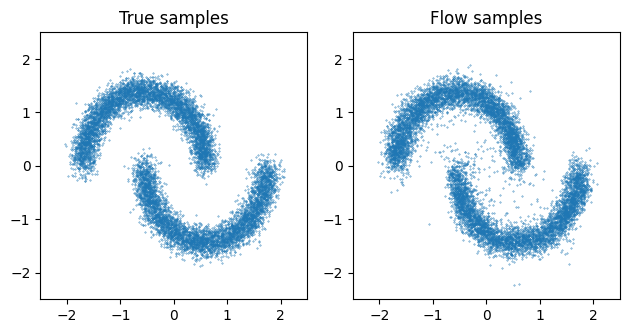

In [ ]:
key, subkey = jr.split(key)
x_samples = flow.sample(subkey, (n_samples,))

fig, axs = plt.subplots(ncols=2)

axs[0].scatter(x[:, 0], x[:, 1], s=0.1)
axs[0].set_title("True samples")

axs[1].scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
axs[1].set_title("Flow samples")

lims = (-2.5, 2.5)
for ax in axs:
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()

In [ ]:
data_file='/Users/mattocallaghan/XPNorm/Data/data'
err_file='/Users/mattocallaghan/XPNorm/Data/err'



data=pd.read_csv(data_file)[['phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','j_m','h_m','ks_m']].values
distance=pd.read_csv(data_file)['mu'].values[:,None]

data_transform=jnp.array([[1., 0., 0., 0., 0., 0.],
       [1., -1., 0., 0., 0., 0.],
       [1., 0., -1., 0., 0., 0.],
       [1., 0., 0., -1., 0., 0.],
       [1., 0., 0., 0., -1., 0.],
       [1., 0., 0., 0., 0., -1.]])



data=np.einsum('ij,bj->bi',np.array(data_transform),np.array(data))

data[:,0]=(data[:,0]-distance[:,0])
n=len(data)
data=data[(data[:,0]<10)*(data[:,0]>-2)]
mean=np.mean(data,axis=0)
std=np.std(data,axis=0)
data=(data-mean)
data=jnp.array(data)

In [ ]:
data.shape[0]/n

0.9375472133624307

In [ ]:
import flows

from jax import grad, jit, random
from jax.example_libraries import stax, optimizers

In [ ]:
rng, flow_rng = random.split(random.PRNGKey(0))
input_dim = data.shape[1]
num_epochs, batch_size = 15, 16
def get_masks(input_dim, hidden_dim=2*6, num_hidden=64):
    masks = []
    input_degrees = jnp.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [jnp.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [jnp.transpose(jnp.expand_dims(d1, -1) >= jnp.expand_dims(d0, 0)).astype(jnp.float32)]
    return masks

def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=12, num_hidden=1)
    act = stax.Relu
    init_fun, apply_fun = stax.serial(
        flows.MaskedDense(masks[0]),
        act,
        flows.MaskedDense(masks[1]),
        act,
        flows.MaskedDense(jnp.tile(masks[2],2)),
    )
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

init_fun = flows.Flow(
    flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 4),
    flows.Normal(),
)





params, log_pdf, sample = init_fun(flow_rng, input_dim)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
opt_state = opt_init(params)

In [ ]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr

def loss(params, inputs):
    return -log_pdf(params, inputs).mean()

@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    gradients = grad(loss)(params, inputs)
    return opt_update(i, gradients, opt_state)

In [ ]:
itercount = itertools.count()

for epoch in range(num_epochs):
    clear_output(wait=True) # Clear plotting

    permute_rng, rng = random.split(rng)
    X = random.permutation(permute_rng, data)
    for batch_index in range(0, len(X), batch_size):
        opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
    
    print(loss(params, data).mean())
    
    params = get_params(opt_state)
    sample_rng, rng = random.split(rng)
    X_syn = sample(rng, params, X.shape[0])
    try:
        plt.hist2d(y=X_syn[:, 0]+mean[0], x=X_syn[:, 1]+mean[1], bins=100)
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.show()
    except:
        continue

params = get_params(opt_state)

KeyboardInterrupt: 

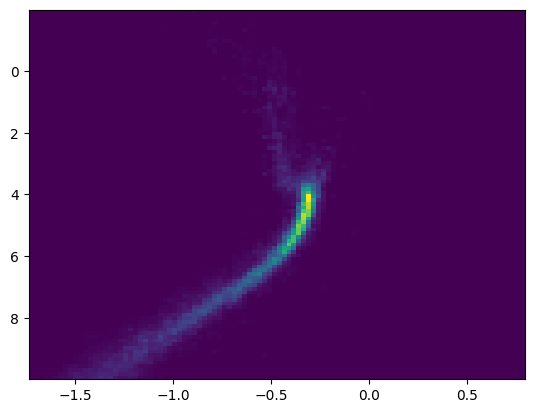

In [ ]:
plt.hist2d(data[:, 1]+mean[1],data[:, 0]+mean[0], bins=100)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

-5.88

In [ ]:
params = get_params(opt_state)

In [ ]:
g = jnp.array([0.7, 0.95])
bp =  jnp.array([0.97, 1.28])
rp =  jnp.array([0.55, 0.69])
j =  jnp.array([0.71, 0.73])/3.1
h =  jnp.array([0.45, 0.47])/3.1
ks =  jnp.array([0.34, 0.36])/3.1

extinction_vector = jnp.array([g.mean(), bp.mean(), rp.mean(), j.mean(), h.mean(), ks.mean()])
extinction_vector=jnp.einsum('ij,j->i',data_transform,extinction_vector)


In [ ]:
(jnp.exp(log_pdf(params, data[:len(data)//32])))

Array([1.1199471e+04, 6.2643135e+03, 4.2783527e+02, ..., 2.5455223e+04,
       1.6465395e+01, 2.9424182e+02], dtype=float32)

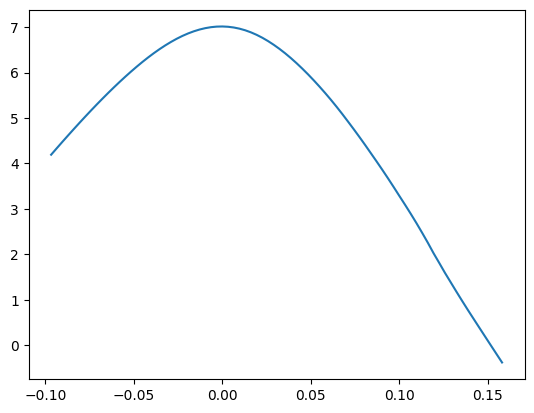

In [ ]:
params = get_params(opt_state)

samples = []

for i in jnp.arange(-0.3, 0.5, 0.01):
    loss = 0
    samples.append(((log_pdf(params, data[:len(data)//32]+i*extinction_vector))).mean())

plt.plot(jnp.arange(-0.3, 0.5, 0.01)/3.1, samples)
plt.show()

In [ ]:
jnp.arange(-0.3, 0.5, 0.01)[jnp.stack(samples).argmax()]

Array(5.9604645e-07, dtype=float32)

In [ ]:
jnp.arange(-0.3, 0.5, 0.01)[jnp.stack(samples).argmax()]
def loss_extinction(i):
    return log_pdf(params, (data-i*extinction_vector)).mean()
np.sqrt(-1/grad((grad(loss_extinction)))(jnp.arange(-0.3, 0.5, 0.01)[jnp.stack(samples).argmax()]))

0.10510808

In [ ]:
data_test=pd.read_csv('/Users/mattocallaghan/XPNorm/Data/data_test')[['phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','j_m','h_m','ks_m']].values
distance=pd.read_csv('/Users/mattocallaghan/XPNorm/Data/data_test')['mu'].values

data_test_scaled=np.einsum('ij,bj->bi',np.array(data_transform),np.array(data_test))
data_test_scaled[:,0]=data_test_scaled[:,0]-distance
data_test_scaled=data_test_scaled[(data_test_scaled[:,0]<10)*(data_test_scaled[:,0]>-2)]
data_test_scaled=data_test_scaled-mean
data_test_scaled=jnp.array(data_test_scaled)

In [ ]:
r=pd.read_csv('/Users/mattocallaghan/XPNorm/Data/data_test')['mu'].reset_index(drop=True)

In [ ]:
r.sort_values()

25797     3.549236
22826     3.550278
73333     3.551160
40652     3.551278
5000      3.551720
           ...    
66959    15.491234
28336    15.620103
63429    15.647076
90727    15.669234
87756    15.720498
Name: mu, Length: 95072, dtype: float64

In [ ]:
ids=r.sort_values().index[:1000].values

In [ ]:
(32*1000)/len(data_test)

0.3365870077415012

In [ ]:
(data_test_scaled-i*extinction_vector)[ids].shape

(1000, 6)

<Axes: ylabel='Density'>

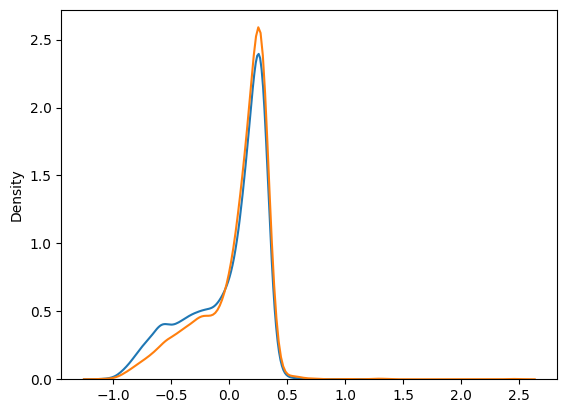

In [ ]:
import seaborn as sn
sn.kdeplot(data[:len(data)//32,1])
sn.kdeplot(data_test_scaled[:len(data_test_scaled)//32,1]-extinction_vector[1]*0.08)


<Axes: ylabel='Density'>

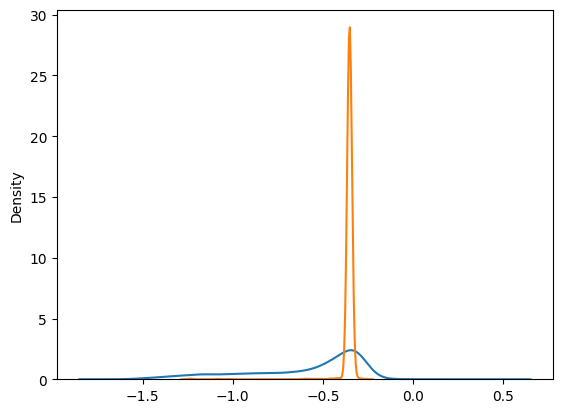

In [ ]:
sn.kdeplot(data[:len(data)//32,1]+mean[1])
sn.kdeplot((data_test_scaled[:len(data_test_scaled)//32,1]+mean[1]-extinction_vector[1]*0.09)[ids])



/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:329: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


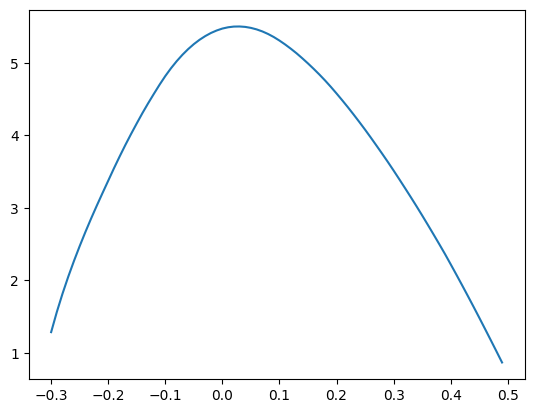

In [ ]:
samples = []
for i in jnp.arange(-0.3, 0.5, 0.01):
    loss = 0
    samples.append(((log_pdf(params, (data_test_scaled-i*extinction_vector)[ids]))).mean())

plt.plot(jnp.arange(-0.3, 0.5, 0.01), samples)
plt.show()

In [ ]:
jnp.arange(-0.3, 0.5, 0.01)[jnp.stack(samples).argmax()]

Array(0.02000064, dtype=float32)

In [ ]:
jnp.arange(-0.3, 0.5, 0.01)[jnp.stack(samples).argmax()]
def loss_extinction(i):
    return log_pdf(params, (data_test_scaled-i*extinction_vector)).mean()
np.sqrt(-1/grad((grad(loss_extinction)))(jnp.arange(-0.3, 0.5, 0.01)[jnp.stack(samples).argmax()]))

0.1062493

# Including Distance

In [ ]:
data_file='/Users/mattocallaghan/XPNorm/Data/data'
err_file='/Users/mattocallaghan/XPNorm/Data/err'



data=pd.read_csv(data_file)[['mu','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','j_m','h_m','ks_m']].values
distance=pd.read_csv(data_file)['mu'].values[:,None]

data_transform=jnp.array([[1., 0., 0., 0., 0., 0.,0],
                            [-1., 1., 0., 0., 0., 0.,0],
                            [0., 1., -1., 0., 0., 0.,0],
                            [0., 1., 0., -1., 0., 0.,0],
                            [0., 1., 0., 0., -1., 0.,0],
                            [0., 1., 0., 0., 0., -1.,0],
                            [0., 1., 0., 0., 0., 0.,-1]])



data=np.einsum('ij,bj->bi',np.array(data_transform),np.array(data))

n=len(data)
data=data[(data[:,1]<10)*(data[:,1]>-2)]
data=data[(data[:,0]<14)*(data[:,0]>4)]
mean=np.mean(data,axis=0)
std=np.std(data,axis=0)
data=(data-mean)
data=jnp.array(data)

In [ ]:
rng, flow_rng = random.split(random.PRNGKey(0))
input_dim = data.shape[1]
num_epochs, batch_size = 15, 32
def get_masks(input_dim, hidden_dim=2*7, num_hidden=64):
    masks = []
    input_degrees = jnp.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [jnp.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [jnp.transpose(jnp.expand_dims(d1, -1) >= jnp.expand_dims(d0, 0)).astype(jnp.float32)]
    return masks

def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=2*7, num_hidden=1)
    act = stax.Relu
    init_fun, apply_fun = stax.serial(
        flows.MaskedDense(masks[0]),
        act,
        flows.MaskedDense(masks[1]),
        act,
        flows.MaskedDense(jnp.tile(masks[2],2)),
    )
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

init_fun = flows.Flow(
    flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5),
    flows.Normal(),
)





params, log_pdf, sample = init_fun(flow_rng, input_dim)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
opt_state = opt_init(params)

In [ ]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr

def loss(params, inputs):
    return -log_pdf(params, inputs).mean()

@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    gradients = grad(loss)(params, inputs)
    return opt_update(i, gradients, opt_state)

-5.1378593


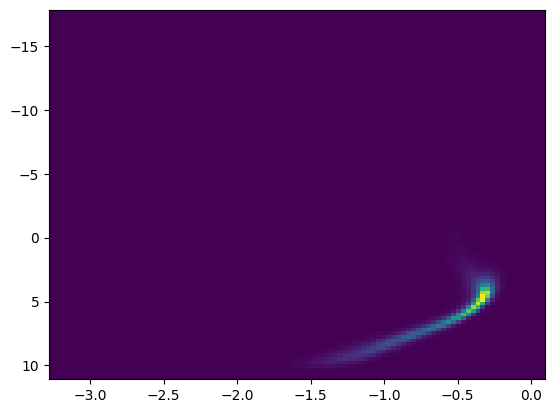

In [ ]:
itercount = itertools.count()

for epoch in range(num_epochs):
    clear_output(wait=True) # Clear plotting

    permute_rng, rng = random.split(rng)
    X = random.permutation(permute_rng, data)
    for batch_index in range(0, len(X), batch_size):
        opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
    
    print(loss(params, data).mean())
    
    params = get_params(opt_state)
    sample_rng, rng = random.split(rng)
    X_syn = sample(rng, params, X.shape[0])
    try:
        plt.hist2d(y=X_syn[:, 1]+mean[1], x=X_syn[:, 2]+mean[2], bins=100)
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.show()
    except:
        continue

params = get_params(opt_state)

In [ ]:
g = jnp.array([0.7, 0.95])
bp =  jnp.array([0.97, 1.28])
rp =  jnp.array([0.55, 0.69])
j =  jnp.array([0.71, 0.73])/3.1
h =  jnp.array([0.45, 0.47])/3.1
ks =  jnp.array([0.34, 0.36])/3.1

extinction_vector = jnp.array([0,g.mean(), bp.mean(), rp.mean(), j.mean(), h.mean(), ks.mean()])
extinction_vector=jnp.einsum('ij,j->i',data_transform,extinction_vector)


In [ ]:
x=sample(rng,params,10000)


/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:329: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


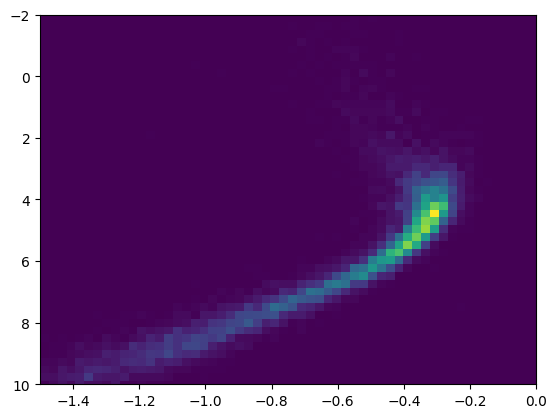

In [ ]:

plt.hist2d(y=x[:, 1]+mean[1], x=x[:, 2]+mean[2], bins=100)
ax = plt.gca()
plt.xlim(-1.5,0.0)
plt.ylim(10,-2)
plt.show()

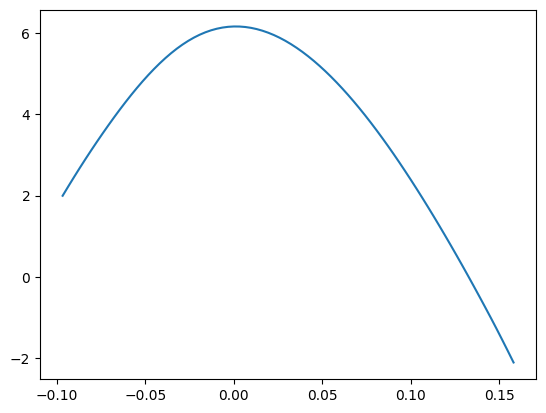

In [ ]:
params = get_params(opt_state)

samples = []

for i in jnp.arange(-0.3, 0.5, 0.01):
    loss = 0
    samples.append(((log_pdf(params, data[:len(data)//32]+i*extinction_vector))).mean())

plt.plot(jnp.arange(-0.3, 0.5, 0.01)/3.1, samples)
plt.show()

In [ ]:
data_test=pd.read_csv('/Users/mattocallaghan/XPNorm/Data/data_test')[['mu','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','j_m','h_m','ks_m']].values
distance=pd.read_csv('/Users/mattocallaghan/XPNorm/Data/data_test')['mu'].values

data_test_scaled=np.einsum('ij,bj->bi',np.array(data_transform),np.array(data_test))
data_test_scaled=data_test_scaled[(data_test_scaled[:,1]<10)*(data_test_scaled[:,1]>-2)]
data_test_scaled=data_test_scaled[(data_test_scaled[:,0]<14)*(data_test_scaled[:,0]>4)]

data_test_scaled=data_test_scaled-mean
data_test_scaled=jnp.array(data_test_scaled)


error = jnp.array([0.1,0.00308123, 0.01036897, 0.0043106 , 0.03507253, 0.03733693, 0.05396977])
error=jnp.einsum('ij,j->i',data_transform,error)

In [ ]:
from jax import grad

5.880456295278407


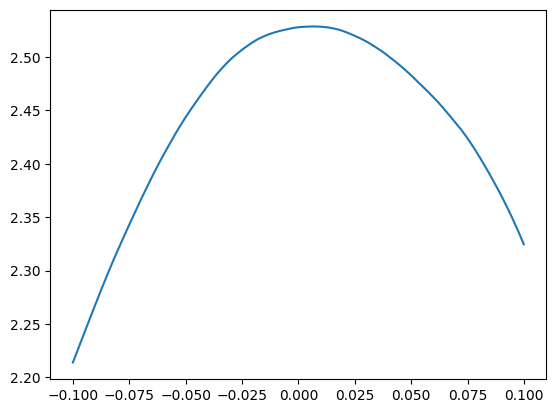

In [ ]:
distance_bound=2.5*np.log10((150)**2/100)
print(distance_bound)
es=jnp.arange(-0.1, 0.1, 0.0001)
inputs_test=data_test_scaled[data_test_scaled[:,0]+mean[0]<distance_bound]
def loss_extinction(i,input_test):
    return log_pdf(params, (input_test-i*extinction_vector)).mean()
losses = vmap(loss_extinction, in_axes=(0, None))(es, inputs_test)
plt.plot(es,losses)

In [ ]:
from jax import vmap

In [ ]:
distance_bound=2.5*np.log10((200)**2/100)
print('------')
print('Amount in bin')
print(len(data_test_scaled[data_test_scaled[:,0]+mean[0]<distance_bound])/len(data_test_scaled))
print('------')
print('MLE E')
print(jnp.arange(-0.1, 0.1, 0.005)[jnp.stack(samples).argmax()])
inputs_test=data_test_scaled[data_test_scaled[:,0]+mean[0]<distance_bound]
def loss_extinction(i,input_test):
    return log_pdf(params, (input_test[None,:]-i*extinction_vector))[0]
losses = vmap(loss_extinction, in_axes=(None, 0))(0, inputs_test)
gradient = vmap(grad(grad(loss_extinction)), in_axes=(None, 0))(0.0, inputs_test)
print('------')
print('Var')
print(1/jnp.sqrt(-1*jnp.mean(gradient)))


------
Amount in bin
0.008157089760878861
------
MLE E
0.020000063
------
Var
0.105870865


# Numpyro

In [ ]:
import numpyro
import numpyro.distributions as dist

In [ ]:
sample(rng, params,1)

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:329: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


Array([[-1.7697586 ,  2.5707877 , -0.1787078 ,  0.16867997,  0.5004921 ,
         0.5123634 ,  0.4104353 ]], dtype=float32)

In [ ]:
sample(rng, params,10).shape

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:329: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


(10, 7)

In [ ]:
from numpyro.distributions import constraints
class NFLow(numpyro.distributions.Distribution):
    support = constraints.real
    def __init__(self, params,size,sampler,log_pdf):
        self.params = params
        self.sampler=sampler
        self.size=size
        self.log_pdf=log_pdf

        super().__init__(batch_shape =jnp.shape(size), event_shape=jnp.shape(jnp.ones(7)[None,:]))
        
    def sample(self, key,sample_shape):
        print(1)
        return self.sampler(key, self.params,sample_shape)
        
    def log_prob(self, value):
        print(value.shape)
        return self.log_pdf(self.params,value[:,:])



In [ ]:
def model(y,sigma,extinction_vector):
    delta_e=numpyro.sample('d_e',dist.Normal(0,1))
    x=numpyro.sample('x',NFLow(params,size=1,sampler=sample,log_pdf=log_pdf))

    with numpyro.plate('data', len(y)):
        
        numpyro.sample('obs', dist.Normal(x-delta_e*extinction_vector, sigma), obs=y)

In [ ]:
data_test.shape

(95072, 7)

In [ ]:
from jax import random

from numpyro.infer import MCMC, NUTS



nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key,y=data_test,sigma=jnp.diag(error**2),extinction_vector=extinction_vector)

ValueError: Incompatible shapes for broadcasting: shapes=[(7, 7), (95072, 7)]

In [ ]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       d_e      1.60      0.00      1.60      1.60      1.60       nan       nan
    x[0,0]      0.79      0.00      0.79      0.79      0.79      0.50      1.00
    x[0,1]     -0.14      0.00     -0.14     -0.14     -0.14      0.50      1.00
    x[0,2]     -0.78      0.00     -0.78     -0.78     -0.78      0.50      1.00
    x[0,3]      0.37      0.00      0.37      0.37      0.37      0.50      1.00
    x[0,4]      1.75      0.00      1.75      1.75      1.75      0.50      1.00
    x[0,5]     -0.71      0.00     -0.71     -0.71     -0.71      0.50      1.00
    x[0,6]      1.67      0.00      1.67      1.67      1.67      0.50      1.00

Number of divergences: 0


In [ ]:
import arviz as az


In [ ]:
posterior_samples = mcmc.get_samples()

In [ ]:
posterior_samples['x'].shape

(1000,)

In [ ]:
posterior_samples = mcmc.get_samples()

# Visualize posterior samples
az.plot_trace(posterior_samples)
plt.show()

az.plot_posterior(posterior_samples)
plt.show()
